#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Задача:

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Вам нужно:

Загрузить данные и выполнить их ресемплирование по одному часу.
Проанализировать данные.
Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
Проверить данные на тестовой выборке и сделать выводы.
Данные лежат в файле taxi.csv. Количество заказов находится в столбце num_orders (от англ. number of orders, «число заказов»).

Инструкция по выполнению проекта:
1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

## Подготовка

### Загружаем данные и ресемплируем по одному часу.

Импорт всех необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import make_scorer, mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Откроем датасет

In [ ]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('C:/Users/goshe/OneDrive/Рабочий стол/Yandex_Praktikum/projects/Datasets/taxi.csv', index_col=[0], parse_dates=[0])

Проверим в хронологичном ли порядке расположены даты и посмотрим информацию о данных:

In [ ]:
display(data.index.is_monotonic)
display(data.head(10))
data.info()

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data.isna().sum()

num_orders    0
dtype: int64

## Анализ

Проведем ресемплирование и построим график

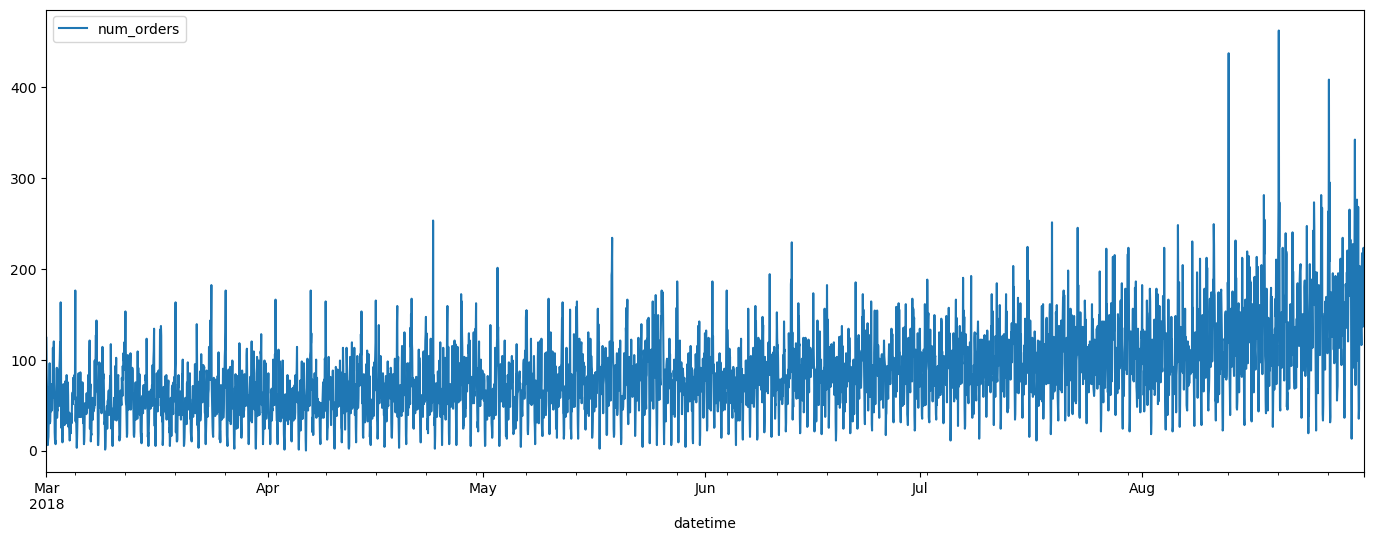

In [ ]:
data = data.resample('1H').sum()
figsize = (17, 6)
data.plot(figsize=figsize)
plt.show()

Разложим временной ряд на три составляющие: тренд, сезонность и остаток

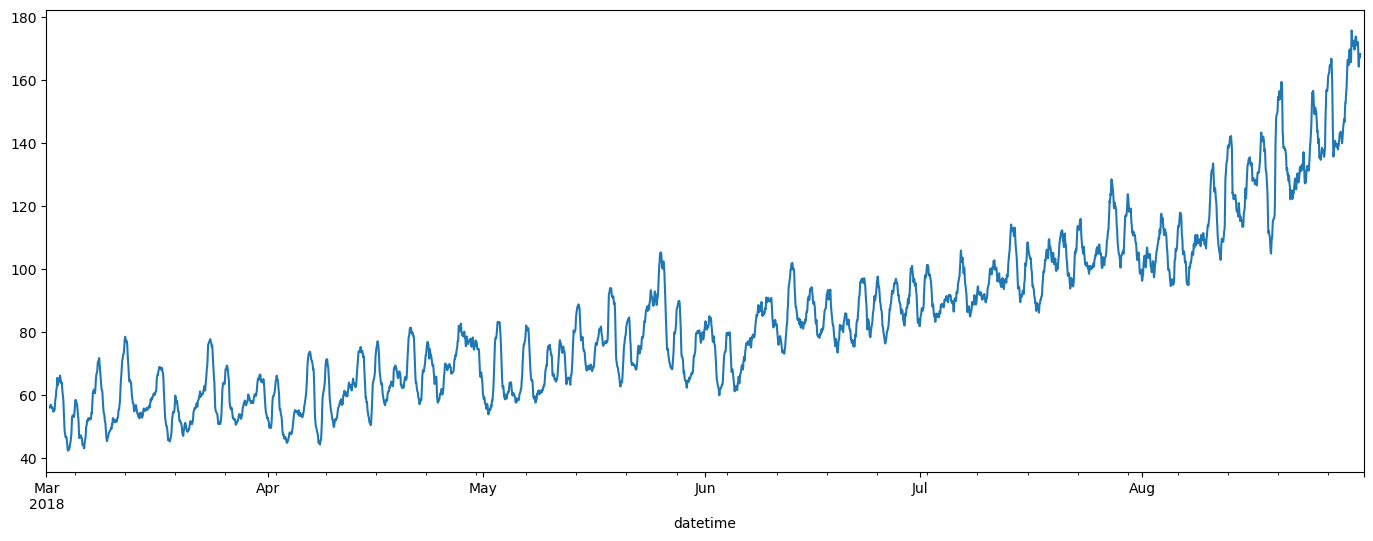

In [ ]:
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(figsize=figsize)
plt.show()

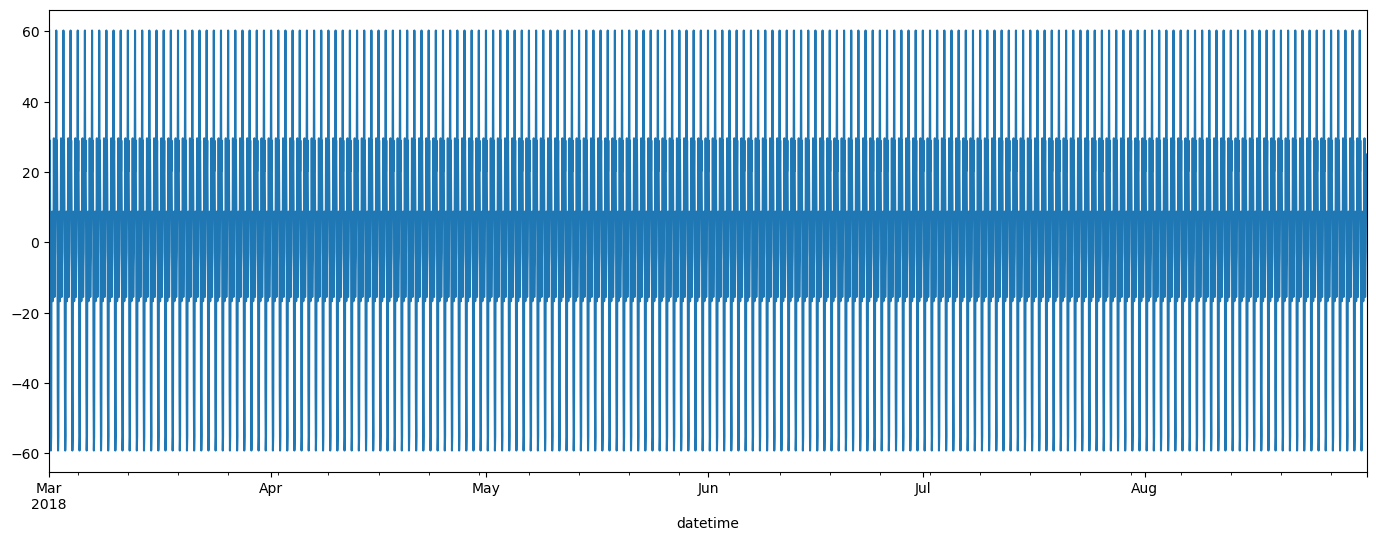

In [ ]:
decomposed_data.seasonal.plot(figsize=figsize)
plt.show()

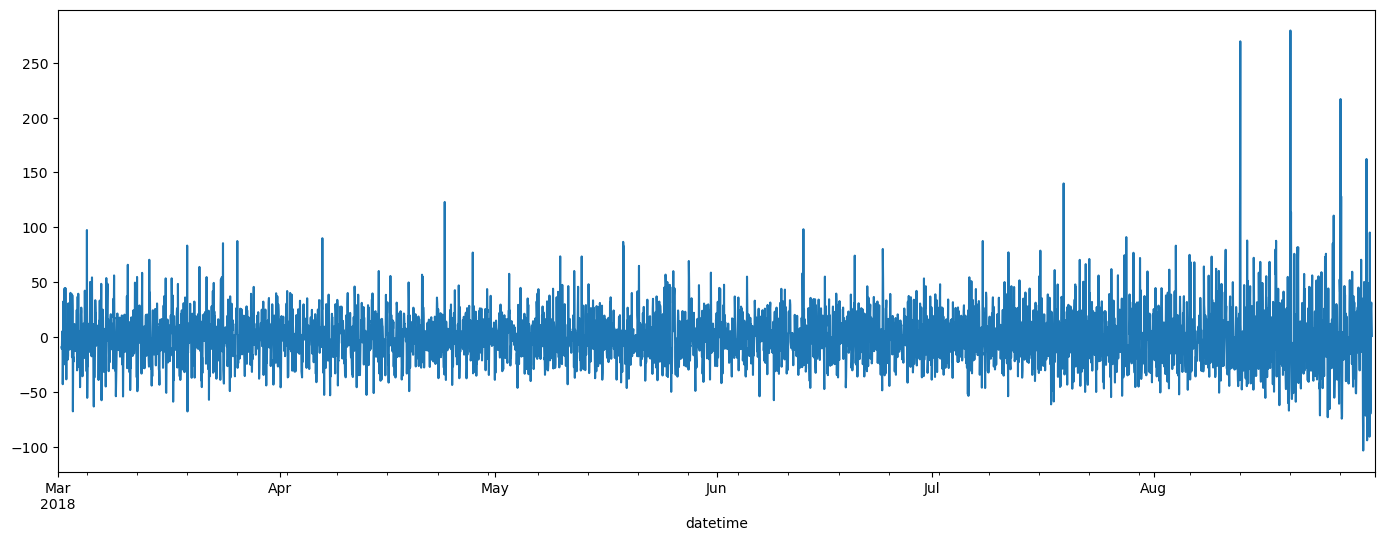

In [ ]:
decomposed_data.resid.plot(figsize=figsize)
plt.show()

Построим тренд, сезонность и остаток для недели c 9 по 15 июля

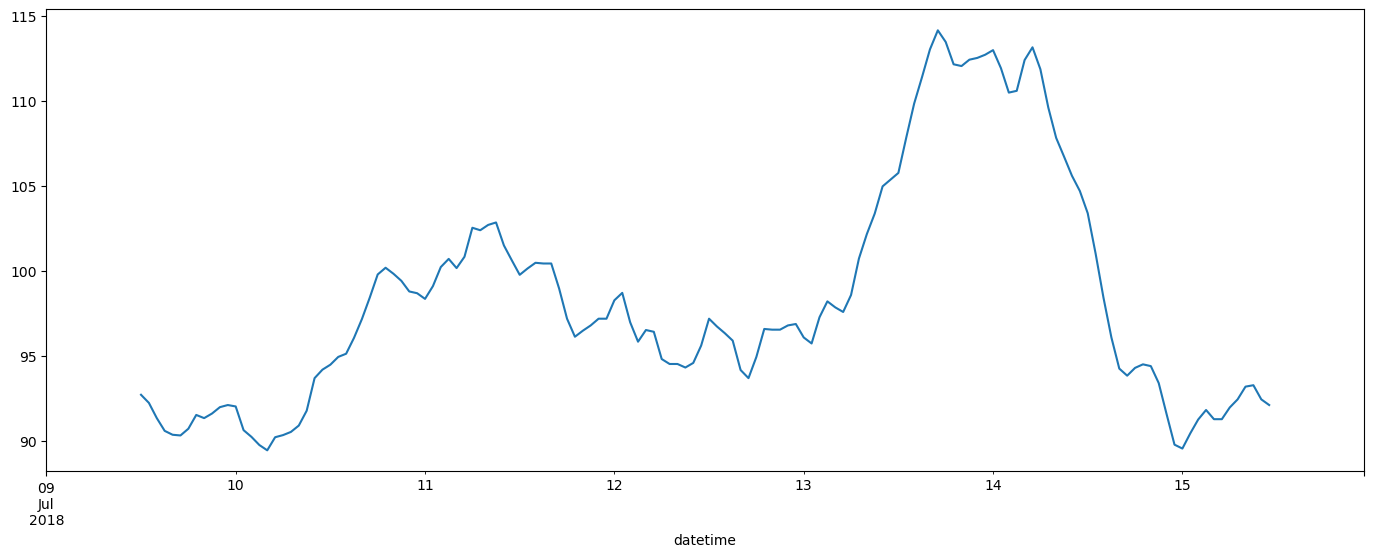

In [ ]:
decomposed_data_week = seasonal_decompose(data['2018-07-09':'2018-07-15'])
decomposed_data_week.trend.plot(figsize=figsize)
plt.show()

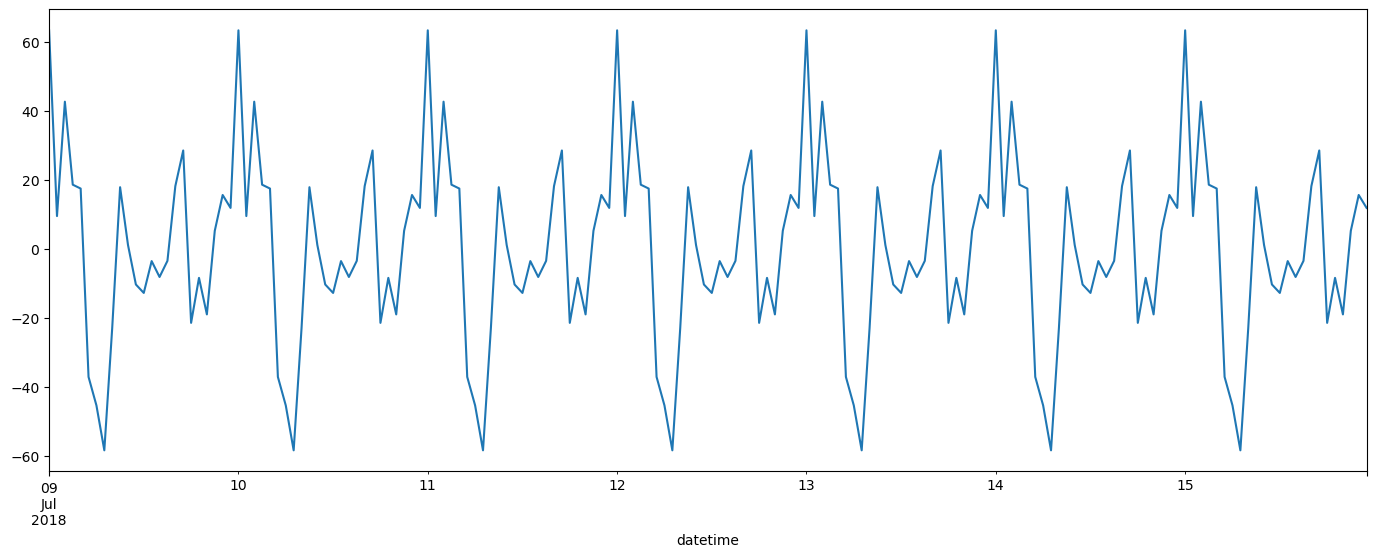

In [ ]:
decomposed_data_week.seasonal.plot(figsize=figsize)
plt.show()

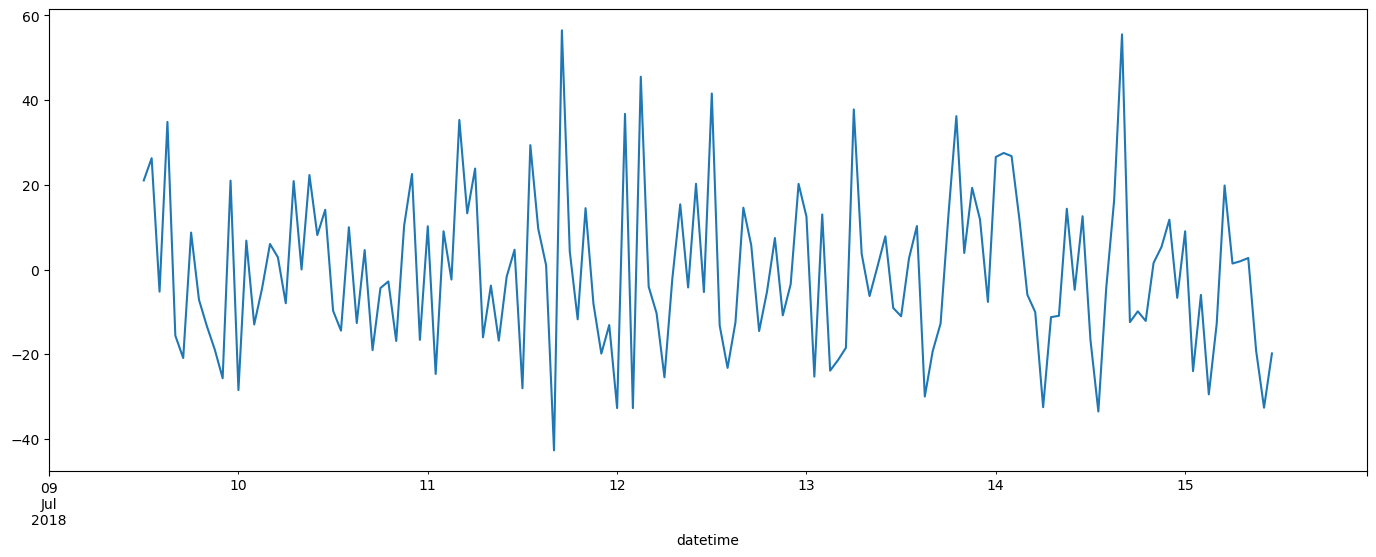

In [ ]:
decomposed_data_week.resid.plot(figsize=figsize)
plt.show()

## Выводы:
- В датасете находится информация о заказе такси с марта по сентябрь 2018 года, с интервалом в 10 минут;
- Пропусков в данных нет;
- Данные расположены в хоронолигическом порядке;
- Мной были построенных графиках тренда, сезонности и остатка за все время наблюдений и за одну неделю;
- Виден восходящий тренд, т.е. услуги "четенького такси" пользуются все большим и большим спросом;
- Заказы такси в течении недели распределены не равномерно - есть пик в середине недели и затем, еще больший пик в пятницу-субботу;
- В течении дня наиболее востребован сервис в ночное время и наименее - в утренне-дневное.

## Обучение

Пропишем функцию для создания признаков: день недели, час -"отстающие значения", скользящее среднее:

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

Применим функцию с лагом до 24 часов и 100-м скользящим средним:

In [ ]:
make_features(data, 24, 100)

Удалим пропуски и посмотрим данные:

In [ ]:
data = data.dropna()

In [ ]:
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


Делим данные на выборки

In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

Определяем фичи и признаки

In [ ]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Функция для расчета метрики RMSE:

In [ ]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5

RMSE_score = make_scorer(RMSE, greater_is_better=False)

### Linear Regression:

In [ ]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

regression = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

regression.fit(features_train, target_train)

regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring=RMSE_score,cv=my_cv)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 28.412402437142486


### Decigion forest:

In [ ]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

forest = RandomForestRegressor()

forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=my_cv)
forest_grid.fit(features_train, target_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026802F64350>,
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 15, 2),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring=make_scorer(RMSE, greater_is_better=False))

Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:

In [ ]:
forest_params = forest_grid.best_params_
print(forest_params)
print('RMSE модели лес решений с Гридсерчем:', forest_grid.best_score_*-1)

{'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 25}
RMSE модели лес решений с Гридсерчем: 26.82011392719258


### CatBoost

In [ ]:
my_cv = TimeSeriesSplit(n_splits=3).split(features_train)

cb = CatBoostRegressor()

cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=my_cv)
cb_grid.fit(features_train, target_train, verbose=100)

0:	learn: 28.8427470	total: 137ms	remaining: 2m 16s
100:	learn: 17.8692599	total: 213ms	remaining: 1.89s
200:	learn: 15.9607824	total: 286ms	remaining: 1.14s
300:	learn: 14.7128169	total: 359ms	remaining: 833ms
400:	learn: 13.5776480	total: 429ms	remaining: 641ms
500:	learn: 12.6540101	total: 500ms	remaining: 498ms
600:	learn: 11.7146676	total: 570ms	remaining: 378ms
700:	learn: 10.9266052	total: 635ms	remaining: 271ms
800:	learn: 10.2835647	total: 699ms	remaining: 174ms
900:	learn: 9.6413875	total: 768ms	remaining: 84.4ms
999:	learn: 9.0798153	total: 844ms	remaining: 0us
0:	learn: 31.8817805	total: 1.25ms	remaining: 1.25s
100:	learn: 20.1994746	total: 90.2ms	remaining: 803ms
200:	learn: 18.5270027	total: 176ms	remaining: 700ms
300:	learn: 17.4868682	total: 263ms	remaining: 611ms
400:	learn: 16.5724681	total: 356ms	remaining: 532ms
500:	learn: 15.8557860	total: 448ms	remaining: 446ms
600:	learn: 15.2104647	total: 539ms	remaining: 358ms
700:	learn: 14.6605748	total: 632ms	remaining: 269

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026802F64F20>,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000268029A6A00>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(RMSE, greater_is_better=False))

Подбираю оптимальные гиперпараметры с помощью кросс-валидации:

In [ ]:
cb_params = cb_grid.best_params_
print(cb_params)
print('RMSE модели модели Catboost с Гридсерч:', cb_grid.best_score_*-1)

{'depth': 4, 'learning_rate': 0.03}
RMSE модели модели Catboost с Гридсерч: 25.786364158056205


### LGBMRegressor

In [ ]:
LGBMR = LGBMRegressor()
param_LGBMR = [{'depth' : [1, 4],
                'learning_rate':[0.03, 0.1],
                'verbose' : [5, 20],
                'random_state':[42]}]

my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
lgbm_GS = GridSearchCV(LGBMR, param_LGBMR, cv=my_cv, scoring='neg_mean_squared_error')
lgbm_GS.fit(features_train, target_train)

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.007781
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.000217 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3057
[LightGBM] [Info] Number of data points in the train set: 971, number of used features: 27
[LightGBM] [Info] Start training from score 57.813594
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and dept

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000026802F64890>,
             estimator=LGBMRegressor(),
             param_grid=[{'depth': [1, 4], 'learning_rate': [0.03, 0.1],
                          'random_state': [42], 'verbose': [5, 20]}],
             scoring='neg_mean_squared_error')

In [ ]:
print(lgbm_GS.best_params_)
print('Среднее качество модели LGBMRegressor с гридсерч:', (lgbm_GS.best_score_*-1)**0.5)

{'depth': 1, 'learning_rate': 0.1, 'random_state': 42, 'verbose': 5}
Среднее качество модели LGBMRegressor с гридсерч: 27.217381283093243


Изучим итоговые показатели метрики RMSE по моделям:

In [ ]:
print('RMSE модели Линейной регрессии:', round(regression_cv_score, 3))
print('RMSE модели Случайного леса:', round(forest_grid.best_score_*-1, 3))
print('RMSE модели CatBoostRegressor:', round(cb_grid.best_score_*-1, 3))
print('RMSE модели LGBMRegressor:', round((lgbm_GS.best_score_*-1)**0.5, 3))

RMSE модели Линейной регрессии: 28.412
RMSE модели Случайного леса: 26.82
RMSE модели CatBoostRegressor: 25.786
RMSE модели LGBMRegressor: 27.217


## Выводы:
- Я обучила 4 модели и определила наилучшие гиперпараметры.
- На кросс-валидации было проведено сравнение моделей.
- Лучшая модель CatBoostRegressor - с RMSE 25.786

## Тестирование

Пропишем функцию для построения сравнительных графиков "целевой признак - предсказание модели":

In [ ]:
def graphicaizer(predictions):
    model_data = pd.DataFrame({"target":target_test, "predict":predictions})
    model_data.plot(figsize=(18, 6))
    model_data['2018-08-22':'2018-08-24'].plot(figsize=(18, 6))

Протестируем CatBoost на тестовой выборке:

In [ ]:
cb_model = CatBoostRegressor(learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=100)
cb_model_predictions = cb_model.predict(features_test)
rmse_cb = mean_squared_error(target_test, cb_model_predictions) ** 0.5

print('RMSE модели CatBoostRegressor:', rmse_cb)

0:	learn: 38.2170015	total: 1.65ms	remaining: 1.65s
100:	learn: 24.2674485	total: 120ms	remaining: 1.07s
200:	learn: 22.7692978	total: 239ms	remaining: 951ms
300:	learn: 21.7085475	total: 355ms	remaining: 825ms
400:	learn: 20.7832879	total: 490ms	remaining: 732ms
500:	learn: 19.9726626	total: 623ms	remaining: 621ms
600:	learn: 19.3182983	total: 749ms	remaining: 497ms
700:	learn: 18.7501925	total: 880ms	remaining: 375ms
800:	learn: 18.2674206	total: 1.01s	remaining: 251ms
900:	learn: 17.8233171	total: 1.13s	remaining: 124ms
999:	learn: 17.4163098	total: 1.27s	remaining: 0us
RMSE модели CatBoostRegressor: 40.66470793767463


Сравниваю наши данные и что мы предсказали по графику:

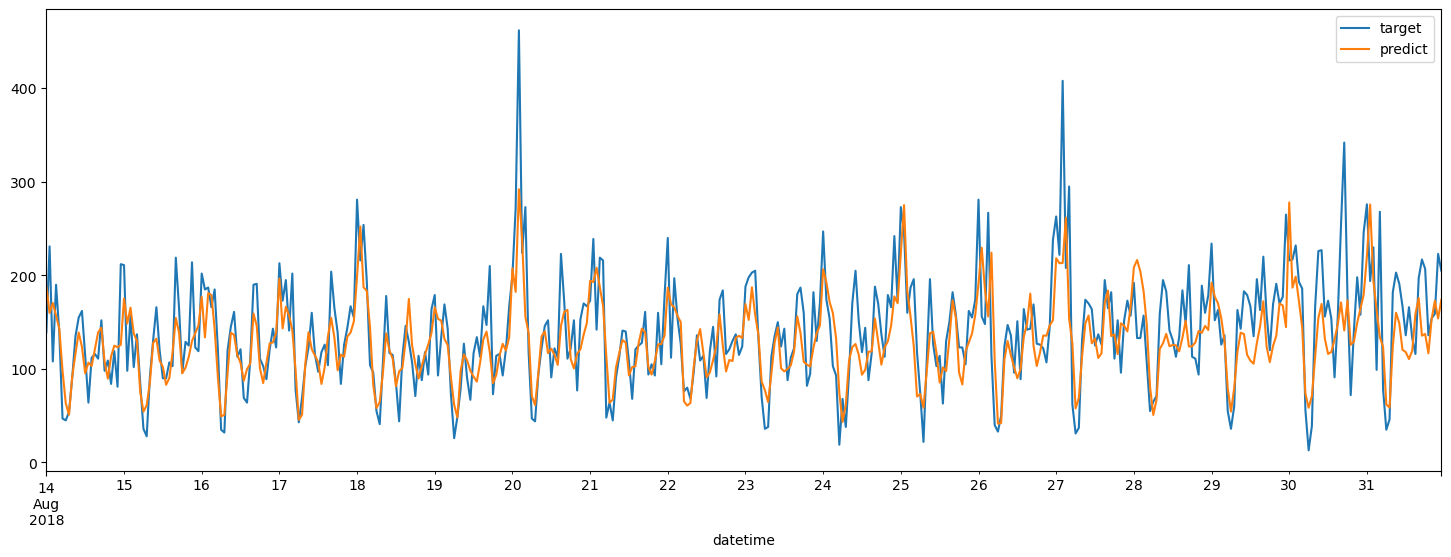

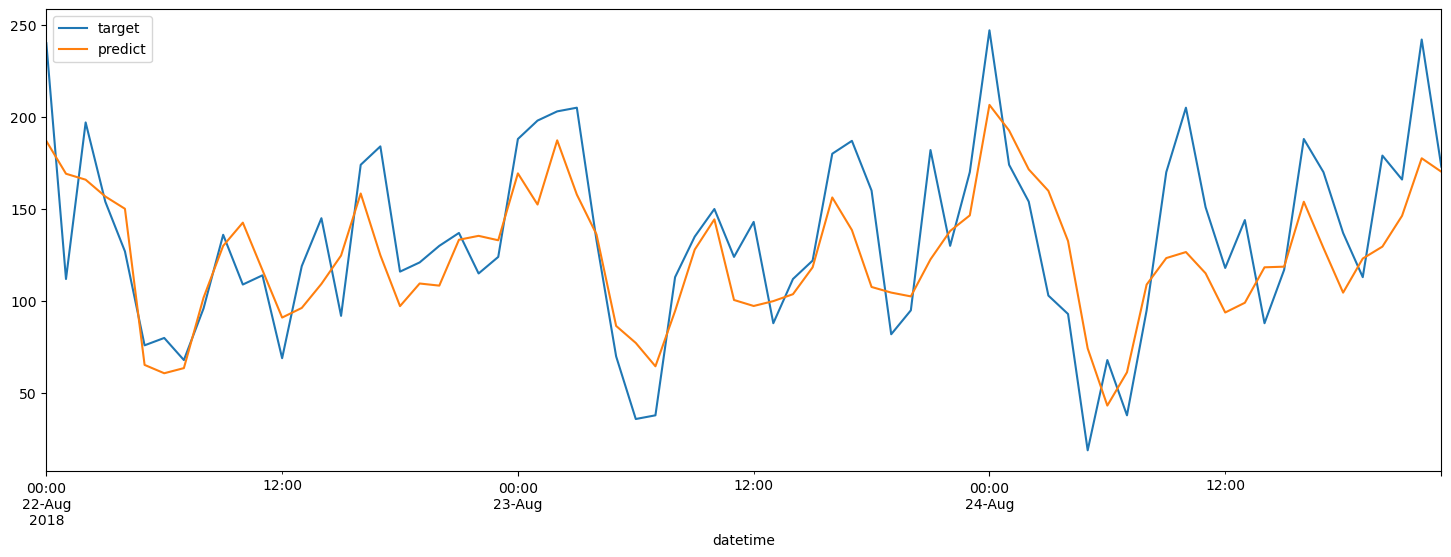

In [ ]:
graphicaizer(cb_model_predictions)

CatBoostRegressor на тестовой выборке показала метрику RMSE - 40,664.

## Общие выводы:

- Датасет был загружен и подготовлен для обучения моделей;
- Был проведен анализ числовых рядов, разложение их на тренд, сезонность и остаток, построены графики;
- Обнаружены следующие тенденции:
  - Виден восходящий тренд, т.е. услуги "четенького такси" пользуются все большим и большим спросом;
  - Заказы такси в течении недели распределены не равномерно - есть пик в середине недели и затем, еще больший пик в пятницу-субботу;
  - В течении дня наиболее востребован сервис в ночное время и наименее - в утренне-дневное;
- К датасету были добавлены дополнительные признаки - день недели, час, "отстающие значения" и скользящее среднее;
- Проведен подбор лучших гиперпараметров для моделей Linean regression, Random Forest, CatBoostRegressor, LGBMRegressor;
- Все модели протестированы на кросс-валидации, замерен RMSE;
- Модель с лучшим показателем - CatBoostRegressor протестирована на тестовой выборке и выдает результат 17,416.
- Для CatBoostRegressor построен график сравнения пресказаний моделей с реальными заказами.